# Connect the Kaggle API to Google Colab

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset.
*https://www.kaggle.com/mrgravelord/complete-pokemon-image-dataset*


In [3]:
!kaggle datasets download -d mrgravelord/complete-pokemon-image-dataset

100% 134M/134M [00:03<00:00, 51.0MB/s]



# Unzip the dataset

In [0]:
!mkdir pokemonData
!unzip /content/complete-pokemon-image-dataset.zip -d /content/pokemonData

# Image sample from the dataset

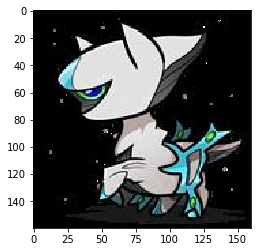

In [8]:
import cv2
import matplotlib.pyplot as plt

img_array = cv2.imread('/content/pokemonData/Arceus/Arceus_10.jpg')
plt.imshow(img_array)
plt.show()

# Import the dependencies

In [4]:
from keras.optimizers import Adam
from keras.models import Model,load_model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense,Input,GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import matplotlib.pyplot as plt
import os 

Using TensorFlow backend.


# Prepare the data

In [33]:
batch_size = 24                                                                 # No. of pictures per batch    
classes = 929                                                                   # No. of pokemons in our dataset
data_gen = ImageDataGenerator(rescale = 1./255,                                 # Defining our image generator    
                              horizontal_flip = True,
                              vertical_flip = False,
                              brightness_range = (0.5, 1.6),
                              rotation_range = 11,
                              validation_split = 0.17)
# Creation train dataset
train_gen = data_gen.flow_from_directory('/content/pokemonData',
                                         target_size = (160,160),               # Our dataset has images of size (160 x 160) 
                                         batch_size = batch_size,
                                         subset = 'training')
# Creation validation dataset
validataion_gen = data_gen.flow_from_directory('/content/pokemonData',
                                               target_size = (160,160),         # Our dataset has images of size (160 x 160) 
                                               batch_size = batch_size,
                                               subset = 'validation')

Found 20941 images belonging to 929 classes.
Found 3705 images belonging to 929 classes.


# Import **InceptionV3**

> ##  Transfer Learning



In [0]:
# Defining our input tensor for our base model, input tensor is the output of layers.Input()
# 160 x 160 x 3 is our image dimensions
tensor = Input(shape = (160,160,3))            
# InceptionV3 is our base model without the top(last) layer, we will add our own layers at the end 
base_model = InceptionV3(include_top = False, weights = 'imagenet', input_tensor = tensor, input_shape = None, pooling = None)
base_model.summary()

# Add our custom layers to InceptionV3

In [35]:
# Getting the (now) top layer from our base model
layer = base_model.layers[-1].output    
# Adding a pooling layer
layer = GlobalMaxPooling2D()(layer)
layer = Dense(1024,activation = 'relu')(layer)
# This will be the last layer of our network : a fully connected layer with 
# softmax-activation for probability distribution between 929( = classes) distinct pokemons
layer = Dense(classes, activation = 'softmax', name = 'Predictions')(layer)

# Our final model
# It starts from first layer of InceptionV3 and ends on our custom layer
model = Model(input = base_model.input, output = layer )

# We'll train the entire network
for layer in model.layers:
    layer.training = True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("Pr...)`
  # This is added back by InteractiveShellApp.init_path()


# Define CallBacks


> ##  We'll be using callbacks to reduce overfitting



In [0]:
# This will reduce the learning rate when our model hasn't improved for 10 epochs 
reduce_LR = ReduceLROnPlateau(monitor = 'val_loss', patience = 10, cooldown = 5, rate = 0.6, min_lr = 1e-18, verbose = 1)
# This will terminate the training of our model earlier than defined if its no longer improving
stop_train = EarlyStopping(monitor = 'val_loss', patience = 24, verbose = 1)

# Compile and Train

In [0]:
# Compiling our model
model.compile(optimizer = Adam(1e-8),loss = 'categorical_crossentropy',metrics = ['accuracy'])

# Training the model!

history = model.fit_generator(train_gen,
                              validation_data = validataion_gen,
                              steps_per_epoch = 20941//batch_size,
                              validation_steps = 3705//batch_size,
                              epochs = 200,
                              shuffle = True,
                              callbacks = [reduce_LR,stop_train])

# Save the trained model!

In [0]:
# Saving our model
model.save('PokeCeptionV3.h5')